# IMPORTS E CONFIGURAÇÕES

## Imports

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler

## Configuração

In [3]:
plt.rcParams['figure.figsize'] = (20, 16)
pd.set_option('display.max_columns', None)

# LOAD DATA

In [4]:
df1 = pkl.load( open( "../data/cleansed/df_cleansed.pkl", "rb" ) )

# PRÉ-PORCESSAMENTO

## Transformação dos Dados

### Rescaling

> **RobustScaler**: Foi escolhido para CompetitionDistance e CompetitionTimeMonth porque esses atributos apresentam outliers. O RobustScaler usa a mediana e os quartis para realizar o escalonamento, tornando-o menos sensível a valores extremos. Isso é útil para preservar a informação presente na maioria dos dados, sem que os outliers distorçam a escala.

> **MinMaxScaler**: Foi escolhido para PromoTimeWeek e Year porque o objetivo é trazer os valores para dentro de um intervalo fixo (0 a 1). O MinMaxScaler é sensível a outliers, mas como o objetivo é apenas garantir que os valores estejam em uma determinada escala, e não necessariamente preservar a distribuição original, ele se torna uma boa opção.

In [ ]:
# --- Rescaling ---
path_preprocessing = '../model/pre-processing'
# RobustScaler para features com outliers
rs_comp_dist = RobustScaler()
df1['CompetitionDistance'] = rs_comp_dist.fit_transform(df1[['CompetitionDistance']].values)
pkl.dump(rs_comp_dist, open(f'{path_preprocessing}/robust_scaler_competition_distance.pkl', 'wb'))

rs_comp_time_month = RobustScaler()
df1['CompetitionTimeMonth'] = rs_comp_time_month.fit_transform(df1[['CompetitionTimeMonth']].values)
pkl.dump(rs_comp_time_month, open(f'{path_preprocessing}/robust_scaler_competition_time_month.pkl', 'wb'))

# MinMaxScaler para as demais features
mms_promo_time_week = MinMaxScaler()
df1['PromoTimeWeek'] = mms_promo_time_week.fit_transform(df1[['PromoTimeWeek']].values)
pkl.dump(mms_promo_time_week, open(f'{path_preprocessing}/minmax_scaler_promo_time_week.pkl', 'wb'))

mms_year = MinMaxScaler()
df1['Year'] = mms_year.fit_transform(df1[['Year']].values)
pkl.dump(mms_year, open(f'{path_preprocessing}/minmax_scaler_year.pkl', 'wb'))

mms_promo2_since_year = MinMaxScaler()
df1['Promo2SinceYear'] = mms_promo2_since_year.fit_transform(df1[['Promo2SinceYear']].values)
# pkl.dump(mms_promo2_since_year, open(f'{path_preprocessing}/minmax_scaler_promo2_since_year.pkl', 'wb'))

mms_comp_open_since_year = MinMaxScaler()
df1['CompetitionOpenSinceYear'] = mms_comp_open_since_year.fit_transform(df1[['CompetitionOpenSinceYear']].values)
# pkl.dump(mms_comp_open_since_year, open(f'{path_preprocessing}/minmax_scaler_competition_open_since_year.pkl', 'wb'))

mms_comp_open_since_month = MinMaxScaler()
df1['CompetitionOpenSinceMonth'] = mms_comp_open_since_month.fit_transform(df1[['CompetitionOpenSinceMonth']].values)
# pkl.dump(mms_comp_open_since_month, open(f'{path_preprocessing}/minmax_scaler_competition_open_since_month.pkl', 'wb'))

mms_promo2_since_week = MinMaxScaler()
df1['Promo2SinceWeek'] = mms_promo2_since_week.fit_transform(df1[['Promo2SinceWeek']].values)
# pkl.dump(mms_promo2_since_week, open(f'{path_preprocessing}/minmax_scaler_promo2_since_week.pkl', 'wb'))

df1['Promo'] = df1['Promo'].astype(int)
df1['Promo2'] = df1['Promo2'].astype(int)

### Encodings

> **StateHoliday e StoreType**, utiliza-se a técnica de One-Hot Encoding devido à inexistência de ordem ou relação hierárquica entre as categorias. Cada categoria (feriado ou tipo de loja) é tratada como uma entidade independente, e o One-Hot Encoding garante que o modelo não interprete erroneamente uma relação ordinal inexistente entre elas, criando colunas binárias distintas para cada categoria.

> **Assortment** - Ordinal Encoding: Ordinal encoding é apropriado aqui porque existe uma ordem clara entre os tipos de sortimento: básico < extra < estendido. O mapeamento para 1, 2 e 3 preserva essa ordem, permitindo que o modelo capture a relação entre os diferentes níveis de sortimento.

In [6]:
# StateHoliday - One Hot Encoding
# state_holiday é um estado, ou é feriado ou não é feriado,
df1 = pd.get_dummies(df1, prefix=['StateHoliday'], columns=['StateHoliday'] )

# StoreType - Label Encoding
# Como store_type não possui uma ordem, podemos usar o LabelEncoder
le_store_type = LabelEncoder()
df1['StoreType'] = le_store_type.fit_transform( df1['StoreType'])
pkl.dump(le_store_type, open(f'{path_preprocessing}/label_encoder_store_type.pkl', 'wb'))
# Assortment - Ordinal Encoding
# Assortment possui ordem, basic < extra < extended
assortmentDict = {'basic': 1,  'extra': 2, 'extended': 3}
df1['Assortment'] = df1['Assortment'].map(assortmentDict)
df1['Assortment'] = df1['Assortment'].astype(int)

### Transformação da Variável Resposta

> A variável resposta 'Sales' é transformada utilizando uma transformação logarítmica (log1p) para reduzir a assimetria e estabilizar a variância dos dados. Essa técnica é valiosa em modelos de regressão, onde se busca uma distribuição normal da variável resposta. Ao aplicar a transformação logarítmica na coluna 'Sales', o modelo se torna mais adequado, minimizando o impacto de outliers e uniformizando a variância ao longo dos valores. A função log1p, que calcula o logaritmo de 1 + x, é utilizada para garantir que valores zero possam ser tratados na transformação.

<Axes: xlabel='Sales', ylabel='Count'>

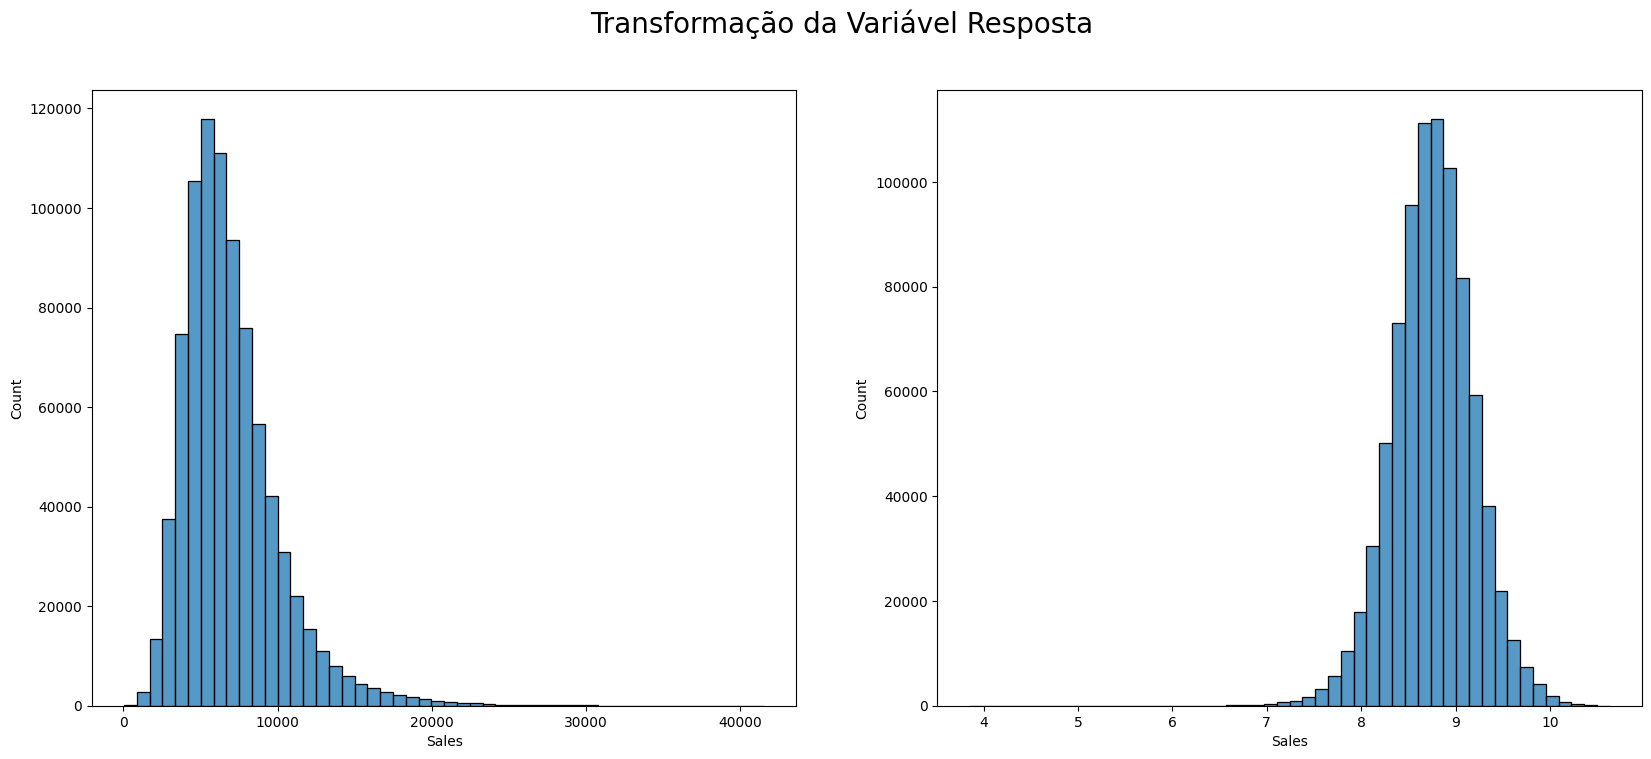

In [6]:
plt.figure(figsize=(20, 8))
plt.suptitle('Transformação da Variável Resposta', fontsize=20)
plt.subplot(1, 2, 1)
sns.histplot(df1['Sales'], bins = 50, kde = False)

df1['Sales'] = np.log1p(df1['Sales'])

plt.subplot(1, 2, 2)
sns.histplot(df1['Sales'], bins = 50, kde = False)

### Transformação dos Valores Cíclicos

> A transformação de valores cíclicos no arquivo envolve a conversão de atributos como 'DayOfWeek', 'Month', 'Day' e 'WeekOfYear' em representações senoidais e cosseno. Essa técnica é aplicada para preservar a natureza cíclica desses atributos, que não são lineares. Por exemplo, a diferença entre o dia 31 e o dia 1 de um mês é de apenas um dia, embora numericamente seja grande. Ao usar seno e cosseno, os valores próximos no ciclo ficam próximos na representação, permitindo que modelos de machine learning capturem melhor os padrões cíclicos. As fórmulas utilizadas garantem que os valores sejam mapeados para um círculo unitário, onde cada ponto representa uma posição no ciclo.

In [7]:
# DayOfWeek
df1['DayOfWeekSin'] = df1['DayOfWeek'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df1['DayOfWeekCos'] = df1['DayOfWeek'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

# Month
df1['MonthSin'] = df1['Month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df1['MonthCos'] = df1['Month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# Day 
df1['DaySin'] = df1['Day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df1['DayCos'] = df1['Day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# WeekOfYear: o ano possui 52 semanas
df1['WeekOfYearSin'] = df1['WeekOfYear'].apply(lambda x: np.sin(x*(2.*np.pi/52))) 
df1['WeekOfYearCos'] = df1['WeekOfYear'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# Seleção de Atributos

## Separação entre Treino e Teste

In [8]:
df2 = df1.copy()
df2 = df2.select_dtypes(exclude=['object'])
# cols_drop: colunas redundantes às colunas: 
# 'Date', 'CompetitionTimeMonth' e 'CompetitionTimeWeek'.
cols_drop = [
    'WeekOfYear', 
    'Day', 
    'Month', 
    'DayOfWeek', 
    'PromoSince', 
    'CompetitionSince'
]
df2 = df2.drop(cols_drop, axis = 1)

# training dataset
x_train = df2[df2['Date'] < '2015-06-19']
y_train = x_train['Sales']

# test dataset - 6 semanas antes da data máxima
x_test = df2[df2['Date'] >= '2015-06-19']
y_test = x_test['Sales']

print('Training Min Date: {}'.format(x_train['Date'].min()))
print('Training Max Date: {}'.format(x_train['Date'].max()))

print('\nTest Min Date: {}'.format(x_test['Date'].min()))
print('Test Max Date: {}'.format(x_test['Date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Aplicação do Boruta

In [ ]:
# training and test dataset for Boruta
x_train_n = x_train.drop(['Date', 'Sales'], axis = 1).values # 'x' fit precisa ser array
y_train_n = y_train.values.ravel() # 'y' fit precisa ser 1-D array

# Define RandomForestRegressor
# n_jobs = -1 usa todos os Cores da máquina, 
# fazendo todo o processamento em paralelo, ou seja, 
# cria todas as árvores em paralelo e rode mais rápido.
rf = RandomForestRegressor(n_jobs = -1)

# Define Boruta
boruta_file = f"{path_preprocessing}/featureSelectionModel/feature_selection_boruta.pkl"

if os.path.exists(boruta_file):
    # Load Boruta if the file exists
    boruta = pkl.load(open(boruta_file, "rb"))
    print("Boruta model loaded from file.")
else:
    # Train Boruta if the file does not exist
    boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42)
    boruta.fit(x_train_n, y_train_n)

    # Save Boruta
    with open(boruta_file, 'wb') as file:
        pkl.dump(boruta, file)
    print("Boruta model trained and saved to file.")

Boruta model loaded from file.


## Exibir as features selecionadas pelo Boruta

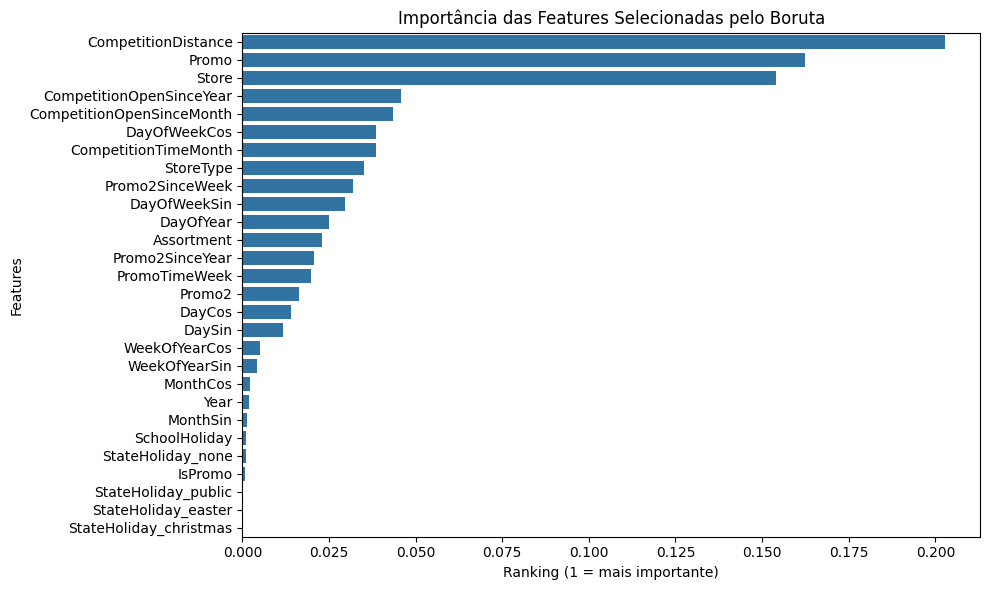

In [10]:
# Capturar todas as features do bourta, reais e shadow features
importances = boruta.estimator.feature_importances_

# x_train_droped: x_train sem as colunas 'Date' e 'Sales'
# Isso é necessário porque o Boruta não considera essas colunas
x_train_droped = x_train.drop(
    ['Date', 'Sales'], 
    axis=1
)

# Número de features reais
n_features = x_train_droped.shape[1]

# Importâncias das features reais
real_importances = importances[:n_features]

# Nome das features reais
feature_names = x_train.drop(
    ['Date', 'Sales'], 
    axis=1
).columns

# DataFrame com nome e importância
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': real_importances,
    'Selected': boruta.support_,
    'Ranking': boruta.ranking_
})

# Ordenar por importância decrescente
importances_df = importances_df.sort_values(
    by='Importance', 
    ascending=False
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_df
)
plt.title('Importância das Features Selecionadas pelo Boruta')
plt.xlabel('Ranking (1 = mais importante)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Atributos Selecionados Manualmente

In [121]:
list_features = [
    'Store',
    'Promo',
    'StoreType',
    'Assortment',
    'CompetitionDistance',
    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2',
    'Promo2SinceWeek',
    'Promo2SinceYear',
    'CompetitionTimeMonth',
    'PromoTimeWeek',
    'DayOfWeekSin',
    'DayOfWeekCos',
    'MonthSin',
    'MonthCos',
    'DaySin',
    'DayCos',
    'WeekOfYearSin',
    'WeekOfYearCos']

# columns to add
feat_to_add = ['Date', 'Sales']

list_features_selected = list_features.copy()
list_features_selected.extend(feat_to_add)

## Salvar as colunas selecionadas manualmente

In [170]:
with open('../model/pre-processing/list_features_selected.pkl', 'wb') as file:
    pkl.dump(list_features_selected, file)

## Salvar Dados de Treino e Teste

In [ ]:
train_test_data = (x_train, x_test, y_train, y_test)
with open('../data/transformed/train_test_data.pkl', 'wb') as file:
    pkl.dump(train_test_data, file)